In [230]:
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact

import torch
from torch import nn
from torchsde import BrownianInterval, sdeint

from scipy import special
from torch.autograd import Function

import dgl
import dgl.function as fn

import networkx as nx

import os
import gc
import pickle

# デバイス設定
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


In [231]:
def printNPZ(npz):
    for kw in npz.files:
        print(kw, npz[kw])

In [232]:
dirName = '/home/uwamichi/jupyter/HiraiwaModel_chem20220922_180005/'

#homeName = './'

params = np.load(dirName+'params.npz')
#traj = np.load(dirName+'result.npz')

printNPZ(params)
#printNPZ(traj)

v0 1.0
r 1.0
D 0.1
A 0.0
L 20
rho 1.0
beta 1.0
A_CFs [0.9 0.5]
A_CIL 0.0
cellType_ratio [0.7 0.3]
quiv_colors ['k' 'r']
kappa 0.5
A_Macdonalds [0.5 0.5]
batch_size 400
state_size 3
brownian_size 1
periodic True
t_max 1000
methodSDE heun
isIto False
stepSDE 0.01


In [233]:
subdir_list = [f.path for f in os.scandir(dirName) if f.is_dir()]

print(subdir_list)

datadir_list = [f for f in subdir_list if 'result.npz' in [ff.name for ff in os.scandir(f)]]

print(datadir_list)

['/home/uwamichi/jupyter/HiraiwaModel_chem20220922_180005/20221026_220625', '/home/uwamichi/jupyter/HiraiwaModel_chem20220922_180005/20221027_020808', '/home/uwamichi/jupyter/HiraiwaModel_chem20220922_180005/20221027_061543', '/home/uwamichi/jupyter/HiraiwaModel_chem20220922_180005/20221027_102254', '/home/uwamichi/jupyter/HiraiwaModel_chem20220922_180005/20221027_144800', '/home/uwamichi/jupyter/HiraiwaModel_chem20220922_180005/ActiveNet_vp_rotsym_batchNorm', '/home/uwamichi/jupyter/HiraiwaModel_chem20220922_180005/20221027_190650', '/home/uwamichi/jupyter/HiraiwaModel_chem20220922_180005/ActiveNet_vp_rotsym_multiStep_transfer_batchNorm', '/home/uwamichi/jupyter/HiraiwaModel_chem20220922_180005/ActiveNet_vp_rotsym_multiStep_fineTuning_batchNorm', '/home/uwamichi/jupyter/HiraiwaModel_chem20220922_180005/20221114_163735', '/home/uwamichi/jupyter/HiraiwaModel_chem20220922_180005/20221114_205206', '/home/uwamichi/jupyter/HiraiwaModel_chem20220922_180005/20221115_004702', '/home/uwamichi/j

In [234]:
modeldirName = dirName + 'ActiveNet_vp_rotsym_noSelfLoop_multiStep_fineTuning_batchNorm/'

#datename = '20220921_160055'
i_model = -1

model_files_list = [[os.path.join(c, ff) for ff in f if ff.endswith('_Model.pt')]
               for c, s, f in os.walk(modeldirName)]
print(model_files_list)

model_files = []
for i in range(len(model_files_list)):
    for j in range(len(model_files_list[i])):
        model_files.append(model_files_list[i][j])
print(model_files)

model_dir = os.path.dirname(model_files[i_model])

model_name = model_files[i_model].replace('_Model.pt', '').replace(modeldirName, '')
print(model_name)

[[], ['/home/uwamichi/jupyter/HiraiwaModel_chem20220922_180005/ActiveNet_vp_rotsym_noSelfLoop_multiStep_fineTuning_batchNorm/20230304_132719/20230304_132719_Model.pt'], [], [], [], []]
['/home/uwamichi/jupyter/HiraiwaModel_chem20220922_180005/ActiveNet_vp_rotsym_noSelfLoop_multiStep_fineTuning_batchNorm/20230304_132719/20230304_132719_Model.pt']
20230304_132719/20230304_132719


In [235]:
class torch_knFunction(Function):
    @staticmethod
    def forward(ctx, input, n):
        numpy_input = input.cpu().detach().numpy()
        result = special.kn(n, numpy_input)
        return torch.as_tensor(result, dtype=input.dtype, device=device)
    
    @staticmethod
    def backward(ctx, grad_output):
        numpy_go = grad_output.cpu().detach().numpy()
        input, n = ctx.saved_tensors
        numpy_input = input.cpu().detach().numpy()
        if n==0:
            grad_kn = -special.kn(1, numpy_input)
        else:
            grad_kn = -(special.kn(n-1, numpy_input) + special.kn(n+1, numpy_input))/2
        result = numpy_go * grad_kn
        return torch.as_tensor(result, dtype=input.dtype, device=device)

class torch_kn(nn.Module):
    def __init__(self, n):
        super(torch_kn, self).__init__()
        self.n = n
        
    def forward(self, input):
        return torch_knFunction.apply(input, self.n)
    
torch_scipy_k0 = torch_kn(0)
torch_scipy_k1 = torch_kn(1)

cutoff = torch.tensor([3.5], device = device)
k1_cutoff = torch_scipy_k1(cutoff)

func_cutoff = nn.ReLU()

def torch_scipy_k1_cutoff(x):
    return func_cutoff(torch_scipy_k1(x) - k1_cutoff)

In [236]:
def J_chemMacdonald(xy, d): # cutoff! --> shift the values
    chemMag = torch_scipy_k1_cutoff(params['kappa'].item() * d) *(params['kappa'].item()/(2*np.pi))
    xy = chemMag * xy
    return xy #torch.nansum(xy, dim=0, keepdim=False)    

if params['periodic']:
    def xy2distance(xy, L):
        dx = xy[:, :1] - xy[:, :1].T   # neighbor - target
        dy = xy[:, 1:] - xy[:, 1:].T
        dx = dx % L
        dy = dy % L
        dx[dx > L/2] = dx[dx > L/2] - L
        dy[dy > L/2] = dy[dy > L/2] - L
        return [dx, dy]
else:
    def xy2distance(xy, L):
        dx = xy[:, :1] - xy[:, :1].T
        dy = xy[:, 1:] - xy[:, 1:].T
        return [dx, dy]    

def J_CF(xy, dr, q):
    #c = torch.unsqueeze(q[0], 1)   # cos, sin of neighbor
    #s = torch.unsqueeze(q[1], 1)
    c = q[:,:1]
    s = q[:,1:]
    xy = (1 + xy[...,:1] * c + xy[...,1:] * s) * xy / 2
    return xy #torch.nansum(xy, dim=0, keepdim=False)

def J_CIL(xy, d, r):
    xy = ((r/d) - 1) * xy
    return xy #torch.nansum(xy, dim=0, keepdim=False)

In [237]:
isIto = params['isIto']

class SDE(torch.nn.Module):
    noise_type = 'scalar'
    sde_type = 'ito' if isIto else 'stratonovich'

    def __init__(self, L, periodic, v0, beta, A_CF, A_CIL, r, A, D):
        super().__init__()
        self.L = L
        self.periodic = periodic
        self.v0 = v0
        self.beta = beta
        self.A_CF = A_CF
        self.A_CIL = A_CIL
        self.r = r
        self.A = A

        self.sigma = torch.zeros((batch_size, state_size, 1), device=device)
        self.sigma[:, 2, 0] = np.sqrt(2*D)
        
    # Drift
    def f(self, t, y):
#        print(y.shape)
        xy = y[:, :2]
#        if self.periodic:
#            xy = xy % L
        xy = xy2distance(xy, self.L)
#        print(np.shape(xy))
#        print(xy[0].shape)
        xy = torch.cat((torch.unsqueeze(xy[0], 2), torch.unsqueeze(xy[1], 2)), 2)
        d = torch.norm(xy, p='fro', dim=2, keepdim=True)   # distance
        dr = torch.heaviside(self.r - d, torch.tensor([0.0], device=device))   # 1 if distance < r, else 0
        xy = dr * torch.nn.functional.normalize(xy, p=2.0, dim=2)   # normalized distance vector
        c = torch.cos(y[:, 2:])
        s = torch.sin(y[:, 2:])

        jcil = J_CIL(xy, d, self.r)
        
        jchem = J_chemMacdonald(xy, d)
        
        dx0 = self.v0 * torch.cat((c, s), 1)
        dx1 = -self.beta * jcil
        dtheta0 = self.A_CF * J_CF(xy, dr, [c,s]) - self.A_CIL * jcil
        dtheta0 = c * dtheta0[:, 1:] - s * dtheta0[:, :1]
        dtheta1 = self.A * c
        dtheta2 = A_Macdonald * (c * jchem[:, 1:] - s * jchem[:, :1])
        return torch.cat((dx0+dx1, dtheta0+dtheta1+dtheta2), 1)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        return self.sigma


In [238]:
if params['periodic']:
    L = torch.tensor(params['L'])
    def calc_dr(r1, r2):
        dr = torch.remainder((r1 - r2), L)
        dr[dr > L/2] = dr[dr > L/2] - L
        return dr
else:
    def calc_dr(r1, r2):
        return r1 - r2
    
def makeGraph(x_data, r_thresh):
        Ndata = x_data.size(0)
        dx = calc_dr(torch.unsqueeze(x_data, 0), torch.unsqueeze(x_data, 1))
        dx = torch.sum(dx**2, dim=2)
        edges = torch.argwhere(dx < r_thresh/2)
        return dgl.graph((edges[:,0], edges[:,1]), num_nodes=Ndata)

In [239]:
def self_propel(p):
    return p * params['v0']

def angle_abs(xy):
    #xy = xy2distance(xy, params['L'])
    #xy = torch.cat((torch.unsqueeze(xy[0], -1), torch.unsqueeze(xy[1], 2)), -1)
    #xy = calc_dr(r_i, r_j)
    d = torch.norm(xy, p='fro', dim=-1, keepdim=True)   # distance
    dr = torch.heaviside(params['r'].item() - d, torch.tensor([0.0], device=xy.device))   # 1 if distance < r, else 0
    xy = dr * torch.nn.functional.normalize(xy, p=2.0, dim=-1)
    return xy, d

def interact_a(xy, d):
    return -params['beta'] * J_CIL(xy, d, params['r'].item())

def torque(xy, d, p_src, p_dst, type_dst):
    jchem = J_chemMacdonald(xy, d)
    dtheta0 = torch.tensor(params['A_CFs'], device=xy.device)[type_dst.long()] * J_CF(xy, 0, p_src) - params['A_CIL'].item() * J_CIL(xy, d, params['r'].item())
    dtheta0 = p_dst[..., :1] * dtheta0[..., 1:] - p_dst[..., 1:] * dtheta0[..., :1]
    dtheta1 = params['A'].item() * p_dst[..., :1]
    dtheta2 = torch.tensor(params['A_Macdonalds'], device=xy.device)[type_dst.long()] * (p_dst[..., :1] * jchem[..., 1:] - p_dst[..., 1:] * jchem[..., :1])    
    return dtheta0 + dtheta1 + dtheta2

In [240]:
class NeuralNet(nn.Module):
    def __init__(self, in_channels, out_channels, Nchannels, dropout=0, batchN=False, flgBias=False):
        super(NeuralNet, self).__init__()

        if dropout:
            self.dropout = nn.Dropout(p=dropout)
        else:
            self.dropout = 0
            
        if batchN:
            self.bNorm1 = nn.BatchNorm1d(Nchannels)
            self.bNorm2 = nn.BatchNorm1d(Nchannels)
            self.bNorm3 = nn.BatchNorm1d(Nchannels)
            
        self.batchN=batchN
        
        self.layer1 = nn.Linear(in_channels, Nchannels, bias=flgBias)
        self.layer2 = nn.Linear(Nchannels, Nchannels, bias=flgBias)
        self.layer3 = nn.Linear(Nchannels, Nchannels, bias=flgBias)
        self.layer4 = nn.Linear(Nchannels, out_channels, bias=flgBias)

        self.activation = nn.ReLU()

    def reset_parameters(self):
        self.layer1.reset_parameters()
        self.layer2.reset_parameters()
        self.layer3.reset_parameters()
        self.layer4.reset_parameters()
        #nn.init.zeros_(self.layer1.weight)
        #nn.init.zeros_(self.layer2.weight)
        #nn.init.zeros_(self.layer3.weight)
        #nn.init.zeros_(self.layer4.weight)
        
    def forward(self, x):
        out = self.activation(self.layer1(x))
        if self.batchN:
            out = self.bNorm1(out)
        if self.dropout:
            out = self.dropout(out)
        
        out = self.activation(self.layer2(out))
        if self.batchN:
            out = self.bNorm2(out)
        if self.dropout:
            out = self.dropout(out)
        
        out = self.activation(self.layer3(out))
        if self.batchN:
            out = self.bNorm3(out)
        if self.dropout:
            out = self.dropout(out)
        
        out = self.layer4(out)

        return out

class ActiveNet(nn.Module):
    def __init__(self, xy_dim, r, dropout=0, batchN=False, bias=False, Nchannels=128):
        super().__init__()

        self.interactNN = NeuralNet(xy_dim*2 + 2, xy_dim, Nchannels, dropout, batchN, bias)

        self.thetaDotNN = NeuralNet(xy_dim*2 + 2, 1, Nchannels, dropout, batchN, bias)
        
        self.selfpropel = nn.Parameter(torch.tensor(0.0, requires_grad=True, device=device))

        #self.Normalizer = nn.Softmax(dim=1)

        self.xy_dim = xy_dim
        
        self.r = r

        self.reset_parameters()

    def reset_parameters(self):
        self.interactNN.reset_parameters()

        self.thetaDotNN.reset_parameters()
        
        nn.init.uniform_(self.selfpropel)

        #self.bias.data.zero_()
        
    def load_celltypes(self, celltype):
        self.celltype = celltype

    def calc_message(self, edges):
        dx = calc_dr(edges.dst['x'], edges.src['x'])#mistake ... calculating x_dst - x_src (should be flipped)

        costheta = torch.cos(edges.dst['theta'])
        sintheta = torch.sin(edges.dst['theta'])

        dx_para = costheta * dx[..., :1] + sintheta * dx[..., 1:]
        dx_perp = costheta * dx[..., 1:] - sintheta * dx[..., :1]

        p_para_src = torch.cos(edges.src['theta'] - edges.dst['theta'])
        p_perp_src = torch.sin(edges.src['theta'] - edges.dst['theta'])

        rot_m_v = self.interactNN(torch.concat((dx_para, dx_perp, 
                                                p_para_src, p_perp_src,
                                                edges.dst['type'], edges.src['type']), -1))

        m_v = torch.concat((costheta * rot_m_v[..., :1] - sintheta * rot_m_v[..., 1:],
                            costheta * rot_m_v[..., 1:] + sintheta * rot_m_v[..., :1]), -1)

        m_theta = self.thetaDotNN(torch.concat((dx_para, dx_perp, 
                                                p_para_src, p_perp_src, 
                                                edges.dst['type'], edges.src['type']), -1))
        
        return {'m': torch.concat((m_v, m_theta), -1)}
        
    def forward(self, xv):
        r_g = makeGraph(xv[..., :self.xy_dim], self.r/2)
        r_g.ndata['x'] = xv[..., :self.xy_dim]
        r_g.ndata['theta'] = xv[..., self.xy_dim:(self.xy_dim+1)]
        r_g.ndata['type'] = self.celltype
        r_g.update_all(self.calc_message, fn.sum('m', 'a'))
        r_g.ndata['a'][..., :self.xy_dim] = r_g.ndata['a'][..., :self.xy_dim] + self.selfpropel * torch.concat((torch.cos(r_g.ndata['theta']), torch.sin(r_g.ndata['theta'])), -1)
        
        return r_g.ndata['a']



In [241]:
filename1 = modeldirName + model_name + '_Model.pt'
gnn_model = torch.load(filename1, map_location=torch.device(device)) #pickle.load(open(filename1, 'rb'))
gnn_model.eval()

filename3 = modeldirName + model_name + '_Separation.npz'
learn_params = np.load(filename3, allow_pickle=True)

printNPZ(learn_params)

dr_thresh 4
T_pred 5
batch_size 8
train_inds [2 9 6 4 3]
valid_inds [7 1]
test_inds [8 5 0]
val_loss_log [[1.63403279 0.11493566]
 [1.59570481 0.1151024 ]
 [1.5764672  0.11543358]
 [1.55472892 0.11587476]
 [1.54151713 0.11615335]
 [1.53351366 0.11645507]
 [1.52429478 0.11667096]
 [1.5201491  0.11672764]
 [1.51461845 0.11697252]
 [1.51065312 0.11719412]
 [1.50759546 0.11734923]
 [1.50427528 0.11750269]
 [1.50065303 0.11732401]
 [1.50009504 0.11725311]
 [1.49723444 0.11737162]
 [1.49572535 0.11729963]
 [1.4941661  0.11728718]
 [1.49268577 0.11731092]
 [1.4917414  0.11721653]
 [1.49045308 0.11708841]
 [1.48883917 0.11705846]
 [1.48662562 0.11690125]
 [1.48532288 0.11683401]
 [1.48446726 0.1165512 ]
 [1.48351788 0.1164945 ]
 [1.48163097 0.11641084]
 [1.48036438 0.11629311]
 [1.47842579 0.11617087]
 [1.4779427  0.11590116]
 [1.47635261 0.11571354]
 [1.47503093 0.1156854 ]
 [1.47337949 0.11555678]
 [1.47259492 0.11564068]
 [1.47153208 0.11548702]
 [1.47073437 0.11525437]
 [1.46819007 0.11497

In [242]:
# threshold distance for making edges
dr_thresh = learn_params['dr_thresh'].item()

# fixed noise strength
D = 0.0 #params['D']

# boundary conditions (L=100 in article)
#L = params['L']
periodic = params['periodic']

# cell type ratio
cellType_ratio = params['cellType_ratio']
quiv_colors = params['quiv_colors']

# numbers of cells, freedom, and noise source
batch_size, state_size, brownian_size = params['batch_size'], 3, 1

# duration of simulation (6400 in the article)
t_max =  params['t_max']# - initTime

# method to solve SDE
#methodSDE = 'euler'
#isIto = True

# time step to simulate
stepSDE = 1


In [243]:
print(gnn_model.state_dict())

OrderedDict([('selfpropel', tensor(0.9251, device='cuda:1')), ('interactNN.layer1.weight', tensor([[ 0.2185,  0.2012,  0.0633, -0.1603, -0.2546,  0.2063],
        [ 0.0789,  0.0199, -0.2185, -0.0179,  0.0370,  0.2715],
        [-0.0823,  0.1029, -0.3984, -0.0192,  0.3186, -0.0922],
        [ 0.0451,  0.2858, -0.0804, -0.3068,  0.0925,  0.0947],
        [-0.4581,  0.0992, -0.2529, -0.3365,  0.3901, -0.0395],
        [-0.0803,  0.0635, -0.0571,  0.2846, -0.2998,  0.3691],
        [ 0.4822,  0.2574,  0.0750,  0.1314,  0.0157, -0.3035],
        [ 0.4956, -0.4538, -0.0259, -0.0735, -0.0517, -0.0602],
        [-0.5238, -0.5016, -0.0672, -0.1873, -0.1848, -0.1180],
        [ 0.3227, -0.3686, -0.2994,  0.1840, -0.3364,  0.3206],
        [-0.3876, -0.3320, -0.1246, -0.0276, -0.3060, -0.2636],
        [ 0.0414, -0.2237,  0.0751, -0.2037,  0.3727, -0.0216],
        [-0.0592, -0.5208, -0.0320,  0.0850, -0.0405, -0.1056],
        [ 0.1455, -0.2446, -0.3514, -0.0719,  0.2618,  0.1284],
        [-0.0

In [244]:
gnn_model.state_dict()['selfpropel']

tensor(0.9251, device='cuda:1')

In [245]:
gnn_model.thetaDotNN

NeuralNet(
  (layer1): Linear(in_features=6, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=1, bias=True)
  (activation): ReLU()
)

In [246]:
plt.rcParams['font.size']=18
plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams['savefig.bbox'] = 'tight'

plt.rcParams['lines.markersize'] = 11.0

plt.rcParams['lines.linewidth'] = 3.5

In [247]:
# make input dummy data

max_distance = dr_thresh/4

dx_grid = torch.linspace(-max_distance, max_distance, 40)
dy_grid = torch.linspace(-max_distance, max_distance, 40)

p_dst = torch.tensor([1.0, 0.0], device=device)

thetap_src = torch.arange(0, 2*np.pi, np.pi/12)
#p_src = torch.stack((torch.cos(thetap_src), torch.sin(thetap_src)), 1).view(1,1,24,2)

type_dst = torch.tensor([0., 1.])
type_src = torch.tensor([0., 1.])

in_grid = torch.cartesian_prod(dx_grid, dy_grid, thetap_src, type_dst, type_src)

in_grid = torch.cat((in_grid[..., :2], torch.cos(in_grid[..., 2:3]),
                     torch.cos(in_grid[..., 2:3]), in_grid[..., 3:]), -1).to(device)

in_grid_shape = [dx_grid.size(0), dy_grid.size(0), thetap_src.size(0), type_dst.size(0), type_src.size(0), 6]

out_grid_shape = in_grid_shape.copy()
out_grid_shape[-1] = -1

In [248]:
print(in_grid_shape)

[40, 40, 24, 2, 2, 6]


In [249]:
with torch.no_grad():
    interact_pred = gnn_model.interactNN(in_grid.view(-1, 6).to(device))
    interact_pred = interact_pred.cpu().reshape(out_grid_shape)
    torque_pred = gnn_model.thetaDotNN(in_grid.view(-1, 6).to(device)).cpu().reshape(out_grid_shape)

In [250]:
with torch.no_grad():
    xy_in, d_in = angle_abs(in_grid[..., :2].view(-1, 2).to(device))
    interact_truth = interact_a(-xy_in, d_in).cpu().reshape(out_grid_shape)
    torque_truth = torque(-xy_in, d_in, in_grid[:,2:4], p_dst.view(-1, 2), in_grid[:, 4:5]).cpu().reshape(out_grid_shape)

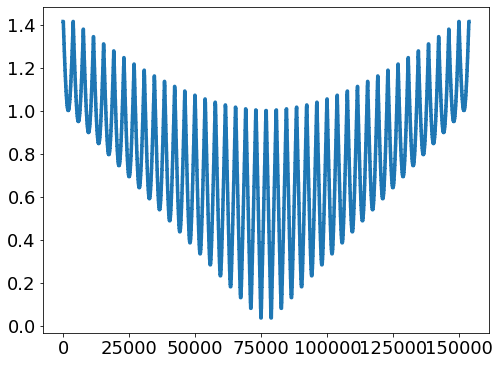

In [251]:
plt.plot(d_in.cpu())

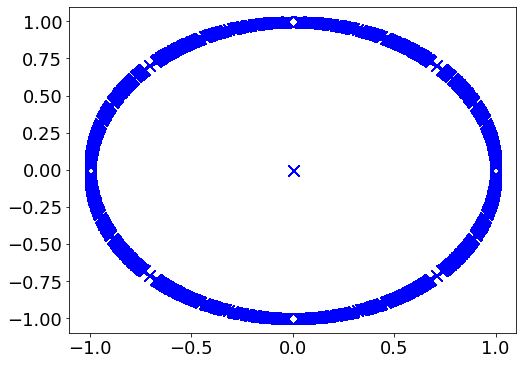

In [252]:
plt.plot(xy_in[:,0].cpu(), xy_in[:,1].cpu(), 'bx')

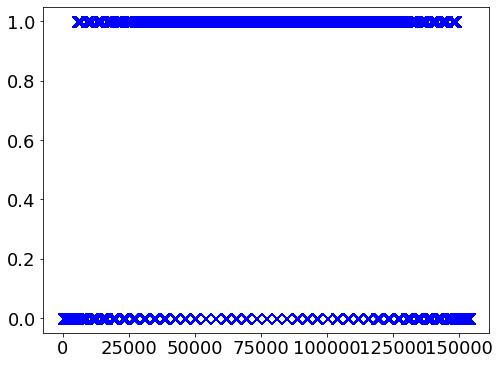

In [253]:
plt.plot((xy_in.cpu()**2).sum(dim=1), 'bx')

In [254]:
print(interact_pred)

tensor([[[[[[ 0.2065,  0.1651],
            [ 0.2338,  0.1916]],

           [[ 0.2293,  0.1656],
            [ 0.2532,  0.1716]]],


          [[[ 0.2105,  0.1648],
            [ 0.2368,  0.1895]],

           [[ 0.2321,  0.1654],
            [ 0.2553,  0.1710]]],


          [[[ 0.2227,  0.1641],
            [ 0.2481,  0.1826]],

           [[ 0.2391,  0.1636],
            [ 0.2618,  0.1672]]],


          ...,


          [[[ 0.2418,  0.1640],
            [ 0.2690,  0.1698]],

           [[ 0.2486,  0.1619],
            [ 0.2730,  0.1579]]],


          [[[ 0.2227,  0.1641],
            [ 0.2481,  0.1826]],

           [[ 0.2391,  0.1636],
            [ 0.2618,  0.1672]]],


          [[[ 0.2105,  0.1648],
            [ 0.2368,  0.1895]],

           [[ 0.2321,  0.1654],
            [ 0.2553,  0.1710]]]],



         [[[[ 0.1851,  0.1507],
            [ 0.2118,  0.1769]],

           [[ 0.2102,  0.1498],
            [ 0.2323,  0.1551]]],


          [[[ 0.1891,  0.1507],
           

In [255]:
print(interact_truth)

tensor([[[[[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          ...,


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]]],



         [[[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          ...,


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
  

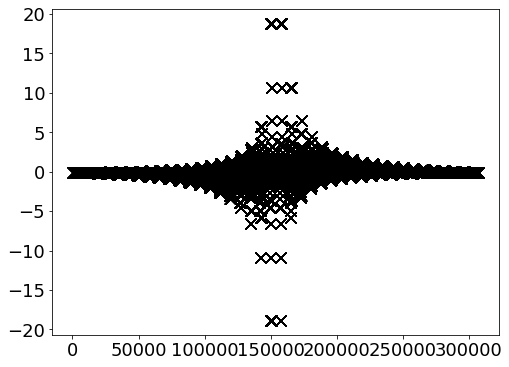

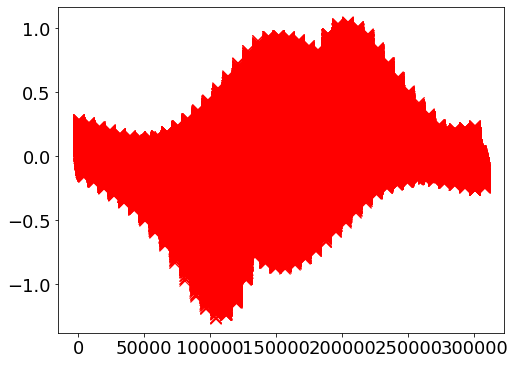

In [256]:
fig,ax = plt.subplots()
ax.plot(interact_truth.cpu().view(-1), 'kx')
fig,ax = plt.subplots()
ax.plot(interact_pred.cpu().view(-1), 'rx')

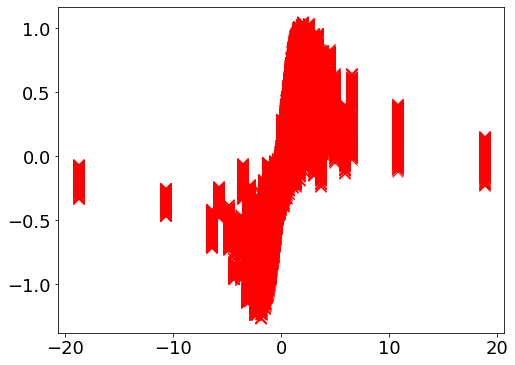

In [257]:
fig,ax = plt.subplots()
ax.plot(interact_truth.cpu().view(-1), interact_pred.cpu().view(-1), 'rx')

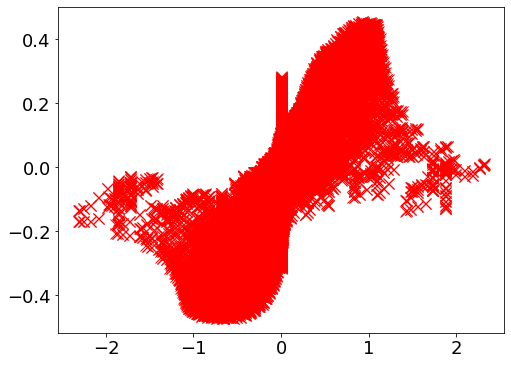

In [258]:
fig,ax = plt.subplots()
ax.plot(torque_truth.cpu().view(-1), torque_pred.cpu().view(-1), 'rx')

In [259]:
plt.rcParams['font.size']=18
plt.rcParams['figure.figsize'] = [18,12]
plt.rcParams['savefig.bbox'] = 'tight'

plt.rcParams['image.cmap'] = 'magma'

plt.rcParams['lines.markersize'] = 11.0

plt.rcParams['lines.linewidth'] = 3.5

In [260]:
clim_interact_true = [-4,4]
clim_torque_true = [-1.2,1.2]

clim_interact_pred = [-0.8,0.8]
clim_torque_pred = [-0.5,0.5]

dy_true, dx_true = np.meshgrid(dx_grid, dy_grid)
dy_pred, dx_pred = np.meshgrid(dx_grid, dy_grid)

def pcolor_subplots(N_i, N_j, ij, xg, yg, cg, cl, title):
    plt.subplot(N_i,N_j,ij)
    plt.pcolor(xg, yg, cg, clim=cl)
    plt.colorbar()
    plt.title(title)
    plt.axis('equal')

@interact(theta_p_j=(0, in_grid_shape[2]-1), type_i=(0, in_grid_shape[3]-1), type_j=(0, in_grid_shape[4]-1))
def f(theta_p_j, type_i, type_j):
    fig = plt.figure()
    pcolor_subplots(3,2,1, dx_true, dy_true, interact_truth[:,:,theta_p_j,type_i,type_j,0], clim_interact_true, 'true interact vx')
    pcolor_subplots(3,2,3, dx_true, dy_true, interact_truth[:,:,theta_p_j,type_i,type_j,1], clim_interact_true, 'true interact vy')
    pcolor_subplots(3,2,5, dx_true, dy_true, torque_truth[:,:,theta_p_j,type_i,type_j,0], clim_torque_true, 'true dtheta/dt')
    pcolor_subplots(3,2,2, dx_pred, dy_pred, interact_pred[:,:,theta_p_j,type_i,type_j,0], clim_interact_pred, 'pred interact vx')
    pcolor_subplots(3,2,4, dx_pred, dy_pred, interact_pred[:,:,theta_p_j,type_i,type_j,1], clim_interact_pred, 'pred interact vy')
    pcolor_subplots(3,2,6, dx_pred, dy_pred, torque_pred[:,:,theta_p_j,type_i,type_j,0], clim_torque_pred, 'pred dtheta/dt')
        


interactive(children=(IntSlider(value=11, description='theta_p_j', max=23), IntSlider(value=0, description='ty…